## Camera calibration

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import glob

def calibrate_camera(path):
    """Given the path to calibration folder and return calibration"""
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob(path)
    fig = plt.figure(figsize=(20,60))
    total_counts = len(images)
    
    img_count = 1
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            
            ax = fig.add_subplot(math.ceil(total_counts / 2), 2, img_count)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img_rgb)
            ax.axis('off')
            img_count += 1
    plt.show()
    
    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)


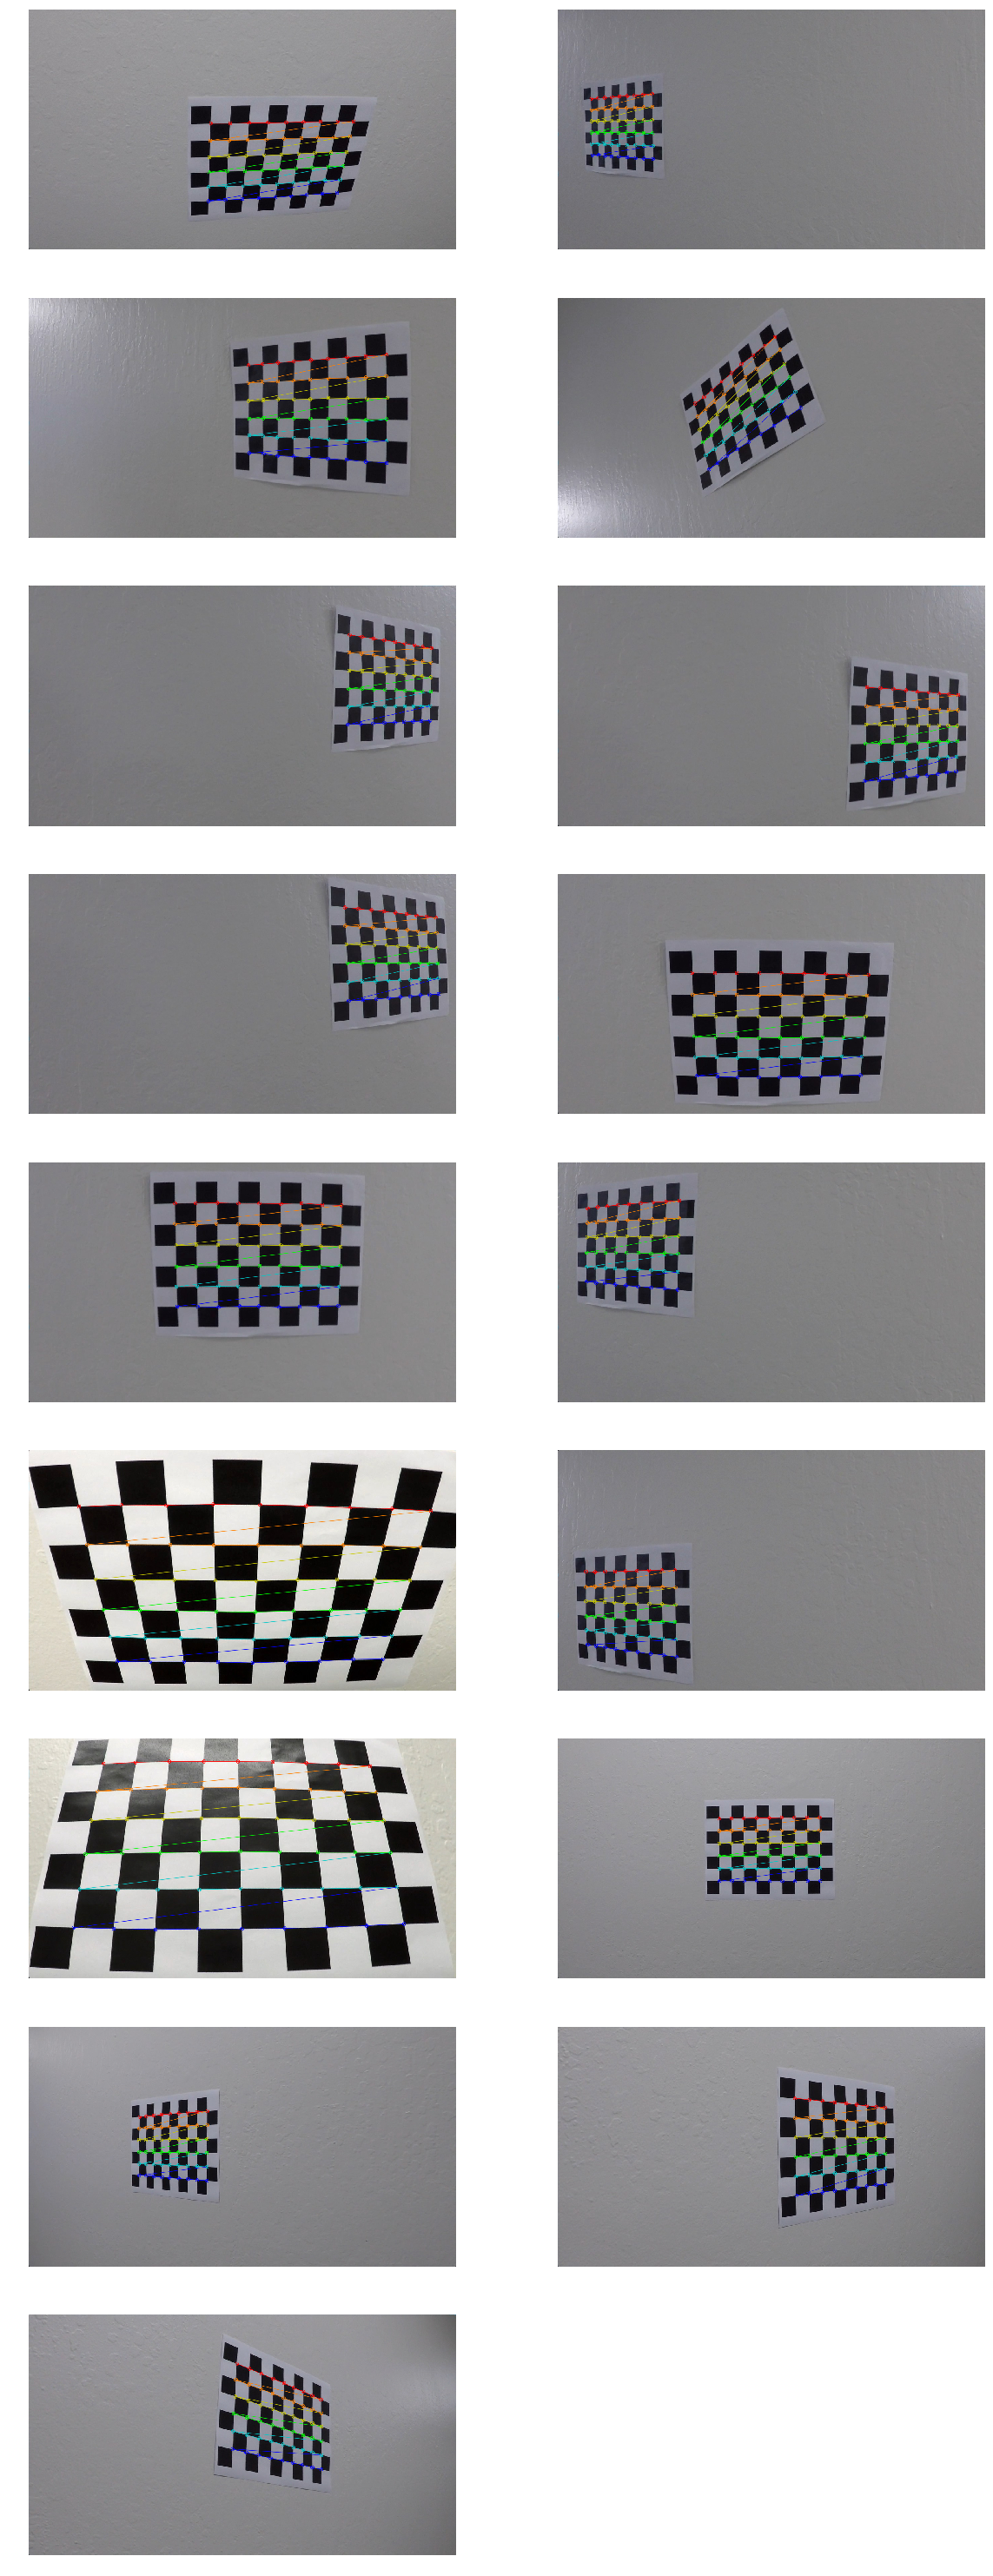

In [2]:
calib = calibrate_camera('./camera_cal/*.jpg')

([], <a list of 0 Text yticklabel objects>)

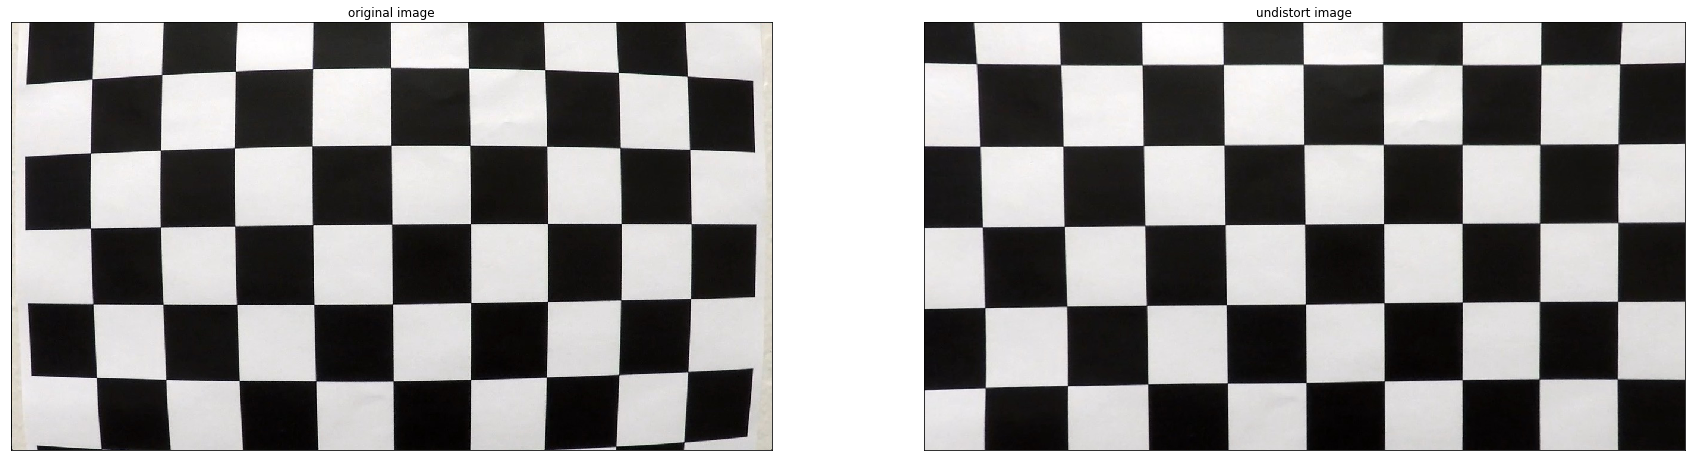

In [3]:
test_distort_img_path = './camera_cal/calibration1.jpg'
test_distort_img = cv2.imread(test_distort_img_path)
undistort_img = cv2.undistort(test_distort_img, calib[1], calib[2], None, calib[1])

plt.figure(figsize = (30, 50))
plt.subplot(121)
plt.imshow(cv2.cvtColor(test_distort_img, cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(undistort_img, cv2.COLOR_BGR2RGB))
plt.title('undistort image')
plt.xticks([])
plt.yticks([])

## IMAGE UNDISTORT

([], <a list of 0 Text yticklabel objects>)

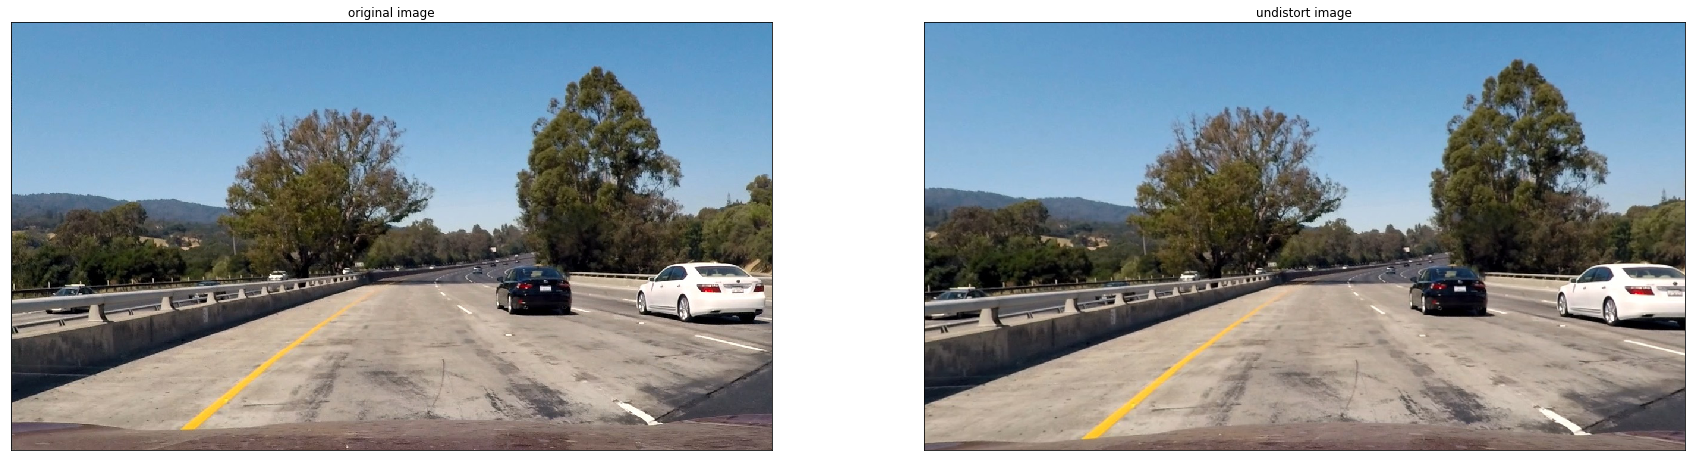

In [4]:
test_distort_img_path = './test_images/test1.jpg'
test_distort_img = cv2.imread(test_distort_img_path)
undistort_img = cv2.undistort(test_distort_img, calib[1], calib[2], None, calib[1])

plt.figure(figsize = (30, 50))
plt.subplot(121)
plt.imshow(cv2.cvtColor(test_distort_img, cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(undistort_img, cv2.COLOR_BGR2RGB))
plt.title('undistort image')
plt.xticks([])
plt.yticks([])

## IMAGE THRESHOLDING

In [5]:
# Gradient magnitude thresholding
def grad_mag_thresh(img, sobel_kernel = 15, thresh_range = (20, 100)):
    """ Image imput is the bgr or rgb"""
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_range[0]) & (scaled_sobel <= thresh_range[1])] = 1
    return sxbinary
    
# Gradient direction thresholding
def grad_dir_thresh(img, sobel_kernel = 21, thresh_range = (0.7, 1.3)):
    """ Image imput is the bgr or rgb"""
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    binary = np.zeros_like(abs_grad_dir)
    binary[(abs_grad_dir >= thresh_range[0]) & (abs_grad_dir <= thresh_range[1])] = 1
    return binary

def grad_mag_thresh2(img, sobel_kernel = 15, thresh_range = (20, 100)):
    """ Image imput is the bgr or rgb"""
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    grad_mag = np.sqrt(sobelx * sobelx + sobely * sobely)
    scaled_sobel = np.uint8(255*grad_mag/np.max(grad_mag))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh_range[0]) & (scaled_sobel <= thresh_range[1])] = 1
    return binary

def hls_thresh(img, thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
    
def image_thresh(img):
    b1 = grad_dir_thresh(img, sobel_kernel = 15, thresh_range = (0.7, 1.2))
    b2 = grad_mag_thresh2(img, sobel_kernel = 3, thresh_range = (15, 255))
    b3 = hls_thresh(img, thresh=(120,255))
    b4 = grad_mag_thresh(img, sobel_kernel = 3, thresh_range = (15, 255))
    b5 = np.zeros_like(b1)
    b5[((b2==1) & (b1==1)) | (b3 == 1) | (b4 == 1)] = 1
    return b5   

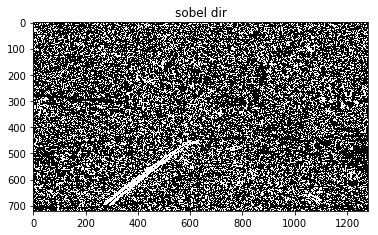

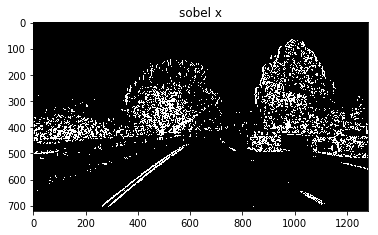

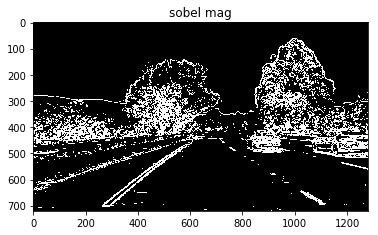

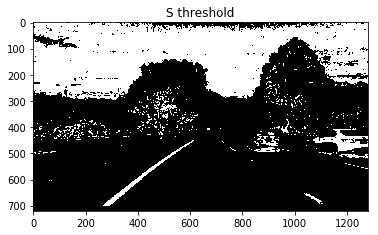

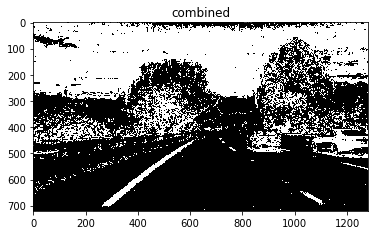

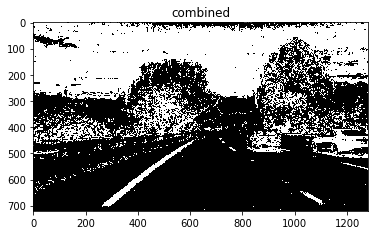

In [6]:
undistort_img_rgb = cv2.cvtColor(undistort_img, cv2.COLOR_BGR2RGB)
b1 = grad_dir_thresh(undistort_img_rgb, sobel_kernel = 15, thresh_range = (0.7, 1.2))
b2 = grad_mag_thresh(undistort_img_rgb, sobel_kernel = 3, thresh_range = (15, 255))
b3 = grad_mag_thresh2(undistort_img_rgb, sobel_kernel = 3, thresh_range = (15, 255))
b5 = hls_thresh(undistort_img_rgb, thresh=(120,255))
b6 = np.zeros_like(b1)
b6[(b5==1) | ((b3==1) & (b1==1)) | b2 == 1] = 1
fig = plt.figure()
plt.imshow(b1, cmap='gray')
plt.title("sobel dir")
fig = plt.figure()
plt.imshow(b2, cmap='gray')
plt.title("sobel x")
fig = plt.figure()
plt.imshow(b3, cmap='gray')
plt.title("sobel mag")
fig = plt.figure()
plt.imshow(b5, cmap='gray')
plt.title("S threshold")
plt.figure()
plt.imshow(b6, cmap='gray')
plt.title("combined")

b7 = image_thresh(undistort_img_rgb)
plt.figure()
plt.imshow(b7, cmap='gray')
plt.title("combined")

## Perspective Transformation

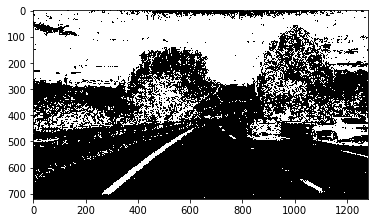

In [7]:
test_img = cv2.imread('./test_images/test1.jpg')
undistort = cv2.undistort(test_img, calib[1], calib[2], None, calib[1])
binary = image_thresh(undistort)
plt.figure()
plt.imshow(binary, cmap='gray')

In [8]:
def image_transform(img):
    src = np.float32([[580, 450], [685, 450], [200, 720], [1100, 720]])
    dst = np.float32([[300, 0],[980, 0],[300, 720],[980, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags = cv2.INTER_LINEAR)
    return warped, M, Minv

## Lane Detection

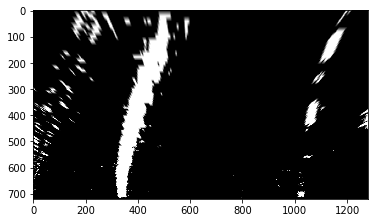

In [9]:
binary_warped, M, Minv = image_transform(binary)
plt.figure()
plt.imshow(binary_warped, cmap = 'gray')

In [10]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin, window, leftx_base, rightx_base, reset_flag = False):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    
    prev_gap= 640
    valid_score_thresh = 500
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    if reset_flag:
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        prev_l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        prev_r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    else:
        prev_l_center = leftx_base;
        prev_r_center = rightx_base;
    
    l_center = prev_l_center
    r_center = prev_r_center
    # Add what we found for the first layer
    window_centroids.append((l_center, r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        l_score = conv_signal[l_min_index:l_max_index].max()
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        # print("left score %d, left center %d " % (l_score, l_center))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        r_score = conv_signal[r_min_index:r_max_index].max()
        # print("right score %d, right center %d" % (r_score, r_center))
        
        # Check the score
        if l_score < valid_score_thresh and r_score < valid_score_thresh:
            l_center = prev_l_center
            r_center = prev_r_center
        elif l_score < valid_score_thresh and r_score >= valid_score_thresh:
            l_center = r_center - prev_gap
        elif l_score >= valid_score_thresh and r_score < valid_score_thresh:
            r_center = l_center + prev_gap
        elif l_score <= r_score:
            correct_weight = r_score / (r_score + l_score)
            l_center = (r_center - prev_gap) * correct_weight + (1. - correct_weight) * l_center
        elif l_score > r_score:
            correct_weight = l_score / (r_score + l_score)
            r_center = (l_center + prev_gap) * correct_weight + (1. - correct_weight) * r_center
            
        prev_l_center = l_center
        prev_r_center = r_center
        prev_gap = r_center - l_center
        
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids

def find_lane(warped, leftx_base, rightx_base, verbose = 0):
    '''warped is the top down view image, set verbose = 1 to show visualization'''
    if verbose == 1:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        plt.figure()
        plt.imshow(warped, cmap = 'gray')
    
    (image_shape_y, image_shape_x) = warped.shape
    window_width = int(np.ceil(image_shape_x / 30) * 2)
    window_height = int(np.ceil(image_shape_y / 18) * 2)
    margin = 100
    
    #Here is the window kernel we use for convolution
    half_width = int(window_width / 2)
    window_kernel = np.ones(half_width)
    window_kernel[:int(half_width * 0.8)] = np.arange(0, 1, 1. / int(half_width * 0.8))
    # window_kernel[int(half_width * 0.9) : half_width] = np.arange(1, 0, -1. / int(half_width - int(half_width * 0.9)))
    window_kernel = np.hstack((window_kernel, window_kernel[::-1]))
    if verbose == 1:
        plt.figure()
        plt.imshow(np.reshape(window_kernel, (-1,window_width)), cmap = 'gray')

    window_centroids = find_window_centroids(warped, window_width, window_height, margin, window_kernel, leftx_base, rightx_base, reset_flag = False)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    l_window_mask = l_points > 0
    r_window_mask = r_points > 0
    warped_mask = warped > 0
    
    l_pixel_mask = l_window_mask & warped_mask
    r_pixel_mask = r_window_mask & warped_mask
    
    left_lane_inds = l_pixel_mask.nonzero()
    right_lane_inds = r_pixel_mask.nonzero()
    
    l_x = left_lane_inds[1]
    l_y = left_lane_inds[0]
    r_x = right_lane_inds[1]
    r_y = right_lane_inds[0]
    left_fit = np.polyfit(l_y, l_x, 2)
    right_fit = np.polyfit(r_y, r_x, 2)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    left_fit_real = np.polyfit(l_y * ym_per_pix, l_x * xm_per_pix, 2)
    right_fit_real = np.polyfit(r_y * ym_per_pix, r_x * xm_per_pix, 2)
    
    ## Visualize
    if verbose == 1:
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together'
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        out_img[l_y, l_x] = (255, 0, 0)
        out_img[r_y, r_x] = (0, 0, 255)
        output = cv2.addWeighted(out_img.astype(np.uint8), 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # Display the final results
        plt.figure()
        plt.imshow(output)
        plt.title('window fitting results')
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        plt.show()
        
    return left_fit, right_fit, left_fit_real, right_fit_real
    

351 1056


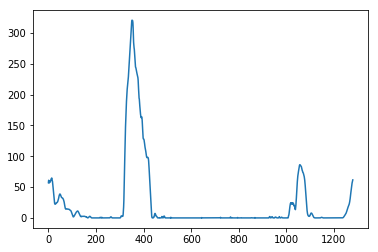

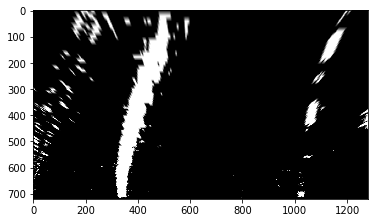

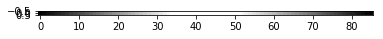

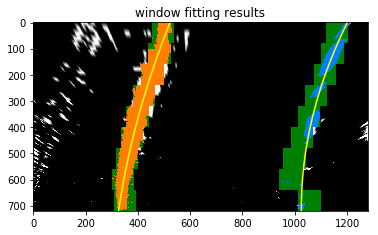

In [11]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(leftx_base, rightx_base)

left_fit, right_fit, left_fit_real, right_fit_real = find_lane(binary_warped, leftx_base, rightx_base, verbose = 1)

## Curvature Radius

In [12]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/640 # meters per pixel in x dimension

y_eval = binary_warped.shape[0]

left_curverad = ((1 + (2*left_fit_real[0]*y_eval*ym_per_pix + left_fit_real[1])**2)**1.5) / np.absolute(2*left_fit_real[0])
right_curverad = ((1 + (2*right_fit_real[0]*y_eval*ym_per_pix + right_fit_real[1])**2)**1.5) / np.absolute(2*right_fit_real[0])

print(left_curverad, 'm', right_curverad, 'm')


866.771534796 m 433.139130341 m


## Drawing

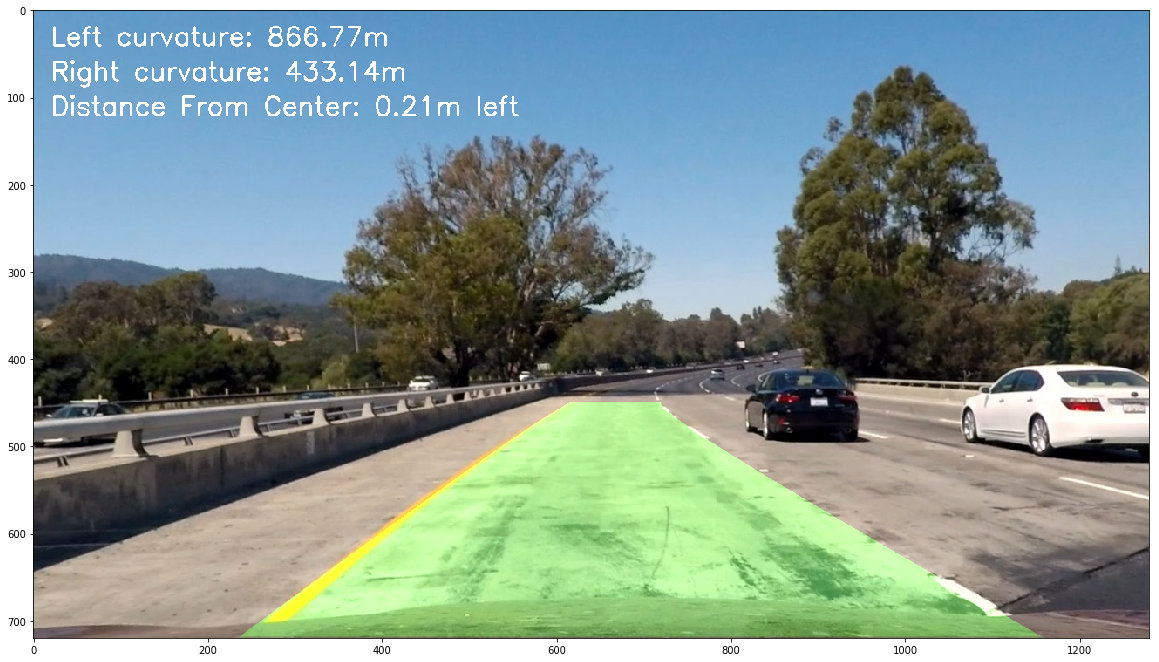

In [13]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (undistort.shape[1], undistort.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)

cv2.putText(result,'Left curvature: %.2fm' % left_curverad, (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
cv2.putText(result,'Right curvature: %.2fm' % right_curverad, (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

midx = 640

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = (-(x_left_pix + x_right_pix)/2 + midx) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
plt.figure(figsize = (20,40))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Add Lane Class

In [14]:
class Line:
    def __init__(self):
        self.initialized = False
        self.lp_w = 0.2
        self.y_eval = 719
        self.midx = 640
        self.lane_gap = 640
        self.mse_thresh = 0.0005
        self.ym_per_pix = 30.0 / 720.0
        self.xm_per_pix = 3.7 / 640
        self.left_curverad = None
        self.right_curverad = None
        self.left_fit = None
        self.right_fit = None
        self.position_from_center = None
        self.x_left_pix = None
        self.x_right_pix = None
        self.x_left_fit_real = None
        self.x_right_fit_real = None
    
    def update(self, left_fit, right_fit, left_fit_real, right_fit_real):
        if self.initialized:
            left_error = abs(self.left_fit[0] - left_fit[0])
            right_error = abs(self.right_fit[0] - right_fit[0])
            if left_error < self.mse_thresh:
                self.left_fit = (1. - self.lp_w) * self.left_fit + self.lp_w * left_fit
                self.left_fit_real = (1. - self.lp_w) * self.left_fit_real + self.lp_w * left_fit_real
            # else:
            #     print("Warning: left line changes too much")
            if right_error < self.mse_thresh:
                self.right_fit = (1. - self.lp_w) * self.right_fit + self.lp_w * right_fit
                self.right_fit_real = (1. - self.lp_w) * self.right_fit_real + self.lp_w * right_fit_real
            # else:
            #     print("Warning: right line changes too much")
        else:
            self.left_fit = left_fit
            self.right_fit = right_fit
            self.left_fit_real = left_fit_real
            self.right_fit_real = right_fit_real
            self.initialized = True
        
        self.left_curverad = ((1 + (2*self.left_fit_real[0]*self.y_eval*self.ym_per_pix + self.left_fit_real[1])**2)**1.5) / np.absolute(2*self.left_fit_real[0])
        self.right_curverad = ((1 + (2*self.right_fit_real[0]*self.y_eval*self.ym_per_pix + self.right_fit_real[1])**2)**1.5) / np.absolute(2*self.right_fit_real[0])

        self.x_left_pix = self.left_fit[0]*(self.y_eval**2) + self.left_fit[1]*self.y_eval + self.left_fit[2]
        self.x_right_pix = self.right_fit[0]*(self.y_eval**2) + self.right_fit[1]*self.y_eval + self.right_fit[2]
        self.position_from_center = (- (self.x_left_pix + self.x_right_pix)/2 + self.midx) * self.xm_per_pix
        

## Pipeline Function
Previous section is used to visualize the method. The pipeline used to process video is defined here


In [15]:
class Pipeline:
    
    def __init__(self, M, Minv, calib, line):
        self.M = M
        self.Minv = Minv
        self.calib = calib
        self.line = line
    
    def update(self, img):
        # Undistort image
        undistort = cv2.undistort(img, calib[1], self.calib[2], None, self.calib[1])
        
        # Image Thresholding
        binary = image_thresh(undistort)
        
        # Image Transform
        binary_warped = cv2.warpPerspective(binary, self.M, (binary.shape[1], binary.shape[0]), flags = cv2.INTER_LINEAR)
        
        # Find lane
        if not self.line.initialized:
            histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        else:
            leftx_base = self.line.x_left_pix
            rightx_base = self.line.x_right_pix
        
        left_fit, right_fit, left_fit_real, right_fit_real  = find_lane(binary_warped, leftx_base, rightx_base, verbose = 0)
        
        self.line.update(left_fit, right_fit, left_fit_real, right_fit_real )
        
        # Drawing
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = self.line.left_fit[0]*ploty**2 + self.line.left_fit[1]*ploty + self.line.left_fit[2]
        right_fitx = self.line.right_fit[0]*ploty**2 + self.line.right_fit[1]*ploty + self.line.right_fit[2]
        
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (undistort.shape[1], undistort.shape[0])) 

        # Combine the result with the original image
        result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)

        cv2.putText(result,'Left curvature: %.2fm' % self.line.left_curverad, (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        cv2.putText(result,'Right curvature: %.2fm' % self.line.right_curverad, (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
        # Find the lane curverad by Harmonic mean
        lane_curvature = 2 * self.line.left_curverad * self.line.right_curverad / (self.line.left_curverad + self.line.right_curverad)
        cv2.putText(result,'Lane curvature: %.2fm' % lane_curvature, (20,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

        midx = 640

        if self.line.position_from_center < 0:
            text = 'left'
        else:
            text = 'right'
        cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(self.line.position_from_center), text),(20,160), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

        return result
    
        

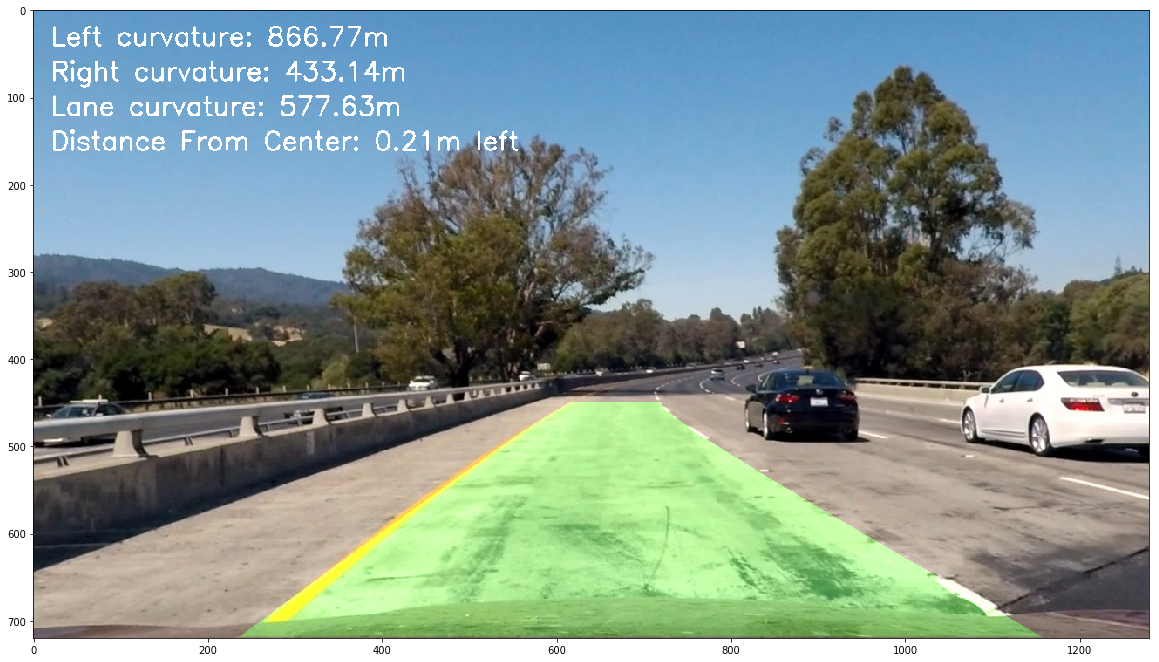

In [16]:
line = Line()
pp = Pipeline(M, Minv, calib, line)
test_img = cv2.imread('./test_images/test1.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
new_img = pp.update(test_img)

plt.figure(figsize = (20,40))
plt.imshow(new_img)



In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line = Line()
pp = Pipeline(M, Minv, calib, line)

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pp.update) #NOTE: this function expects color images!!
%time output_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:39<00:00,  3.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 15s, sys: 1min 21s, total: 8min 36s
Wall time: 6min 39s
